# 라이브러리 가져오기

In [ ]:
import requests                      # HTTP 요청!
from bs4 import BeautifulSoup        # 웹 페이지 파싱
import time                          # 시간 관련 유틸리티
import threading                     # 기본 스레드 기능
from concurrent.futures import ThreadPoolExecutor  # 고수준 병렬 처리
import matplotlib.pyplot as plt      # 그래프 시각화
import pandas as pd                  # 데이터 처리 및 분석
import json                          # JSON 데이터 인코딩/디코딩

# 크롤링 함수 정의

In [11]:
# -----------------------------------------------------------------------------
# 1. 크롤링 함수 정의
# -----------------------------------------------------------------------------

def parse_book_data(book_soup):
    """📘 단일 책 HTML 요소에서 제목, 가격, 평점 정보를 추출하는 함수"""
    
    # 책 제목 추출 (HTML 구조에서 <h3><a title="...">)
    title = book_soup.h3.a['title']
    
    # 가격 정보 추출 (예: '£51.77')
    price_text = book_soup.find('p', class_='price_color').get_text()
    
    # 유니코드 인코딩 문제로 인해 'Â£'가 나타나는 경우를 대비해 제거
    price = float(price_text.replace('Â£', '').replace('£', '')) 
    
    # 평점 클래스 예: <p class="star-rating Three"> → 'Three' 추출
    rating_text = book_soup.find('p', class_='star-rating')['class'][1]
    
    # 평점 텍스트를 숫자로 매핑
    rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
    rating = rating_map.get(rating_text, 0)  # 매핑되지 않으면 기본값 0

    # 추출한 데이터를 딕셔너리로 반환
    return {
        'title': title,
        'price': price,
        'rating': rating
    }

def fetch_and_parse_page(url):
    """🌐 단일 페이지를 가져와 해당 페이지의 모든 책 데이터를 파싱하는 함수"""
    
    try:
        # 해당 URL에 HTTP 요청 (최대 10초 대기)
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # 상태 코드가 4xx, 5xx이면 예외 발생
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return []  # 에러 발생 시 빈 리스트 반환

    # HTML 파싱
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # 책 정보가 담긴 <article class="product_pod"> 요소들을 모두 찾기
    books = soup.find_all('article', class_='product_pod') 

    # 각 책 요소에 대해 데이터 파싱
    page_data = []
    for book in books:
        page_data.append(parse_book_data(book))
    
    return page_data  # 현재 페이지의 책 정보 리스트 반환

def get_all_page_urls(base_url="http://books.toscrape.com/"):
    """🔗 사이트 내 모든 페이지의 URL을 수집하는 함수"""
    
    page_urls = []                   # 페이지 URL을 담을 리스트
    current_url = base_url           # 시작 페이지 설정
    
    while True:
        print(f"Collecting page URL: {current_url}")
        
        try:
            # 현재 페이지 요청
            response = requests.get(current_url, timeout=10)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error collecting page URLs from {current_url}: {e}")
            break  # 에러 발생 시 반복 종료

        soup = BeautifulSoup(response.text, 'html.parser')
        
        # 현재 페이지 URL 추가
        page_urls.append(current_url)

        # 다음 페이지가 존재하는지 확인
        next_button = soup.find('li', class_='next')
        if next_button:
            relative_next_url = next_button.a['href']
            # 상대 경로를 절대 경로로 변환 (e.g., "catalogue/page-2.html")
            current_url = requests.compat.urljoin(current_url, relative_next_url)
        else:
            break  # 다음 페이지가 없으면 반복 종료

    return page_urls  # 모든 페이지 URL 리스트 반환

# 속도 측정 함수

In [7]:
# -----------------------------------------------------------------------------
# 2. 속도 측정 함수
# -----------------------------------------------------------------------------

def crawl_single_threaded(urls):
    """🐢 단일 스레드로 모든 페이지를 순차적으로 크롤링하는 함수"""
    
    print("\n--- Starting Single-threaded Crawling ---")
    start_time = time.time()  # 시작 시간 기록
    all_books_data = []       # 전체 책 정보를 담을 리스트

    for url in urls:
        # 각 페이지의 책 데이터를 수집하여 리스트에 추가
        all_books_data.extend(fetch_and_parse_page(url))
        
        # 서버에 부담을 줄이기 위해 약간의 지연
        time.sleep(0.1)

    end_time = time.time()    # 종료 시간 기록
    elapsed_time = end_time - start_time  # 소요 시간 계산

    print(f"--- Single-threaded Crawling Completed. Total {len(all_books_data)} books, Time taken: {elapsed_time:.2f} seconds ---")
    return all_books_data, elapsed_time  # 수집한 데이터와 시간 반환

def crawl_multi_threaded(urls, max_threads=10):
    """🚀 멀티 스레드를 이용해 병렬로 페이지를 크롤링하는 함수"""
    
    print(f"\n--- Starting Multi-threaded Crawling (Max {max_threads} threads) ---")
    start_time = time.time()  # 시작 시간 기록
    all_books_data = []       # 전체 책 정보를 담을 리스트

    # ThreadPoolExecutor: 스레드 풀을 생성하고 병렬 작업 실행
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        
        # 각 URL을 fetch_and_parse_page 함수에 전달하여 작업 제출
        futures = {
            executor.submit(fetch_and_parse_page, url): url
            for url in urls
        }

        # 제출한 작업이 끝날 때까지 기다리고 결과 수집
        for future in futures:
            try:
                page_data = future.result()  # 크롤링 결과 받기
                all_books_data.extend(page_data)
            except Exception as exc:
                # 작업 중 예외가 발생하면 출력
                print(f'{futures[future]} generated an exception: {exc}')

            # 병렬이라도 서버에 약간의 여유를 주기 위한 지연
            time.sleep(0.05)

    end_time = time.time()  # 종료 시간 기록
    elapsed_time = end_time - start_time  # 총 소요 시간 계산

    print(f"--- Multi-threaded Crawling Completed. Total {len(all_books_data)} books, Time taken: {elapsed_time:.2f} seconds ---")
    return all_books_data, elapsed_time  # 수집한 데이터와 시간 반환


# -----------------------------------------------------------------------------
# 3. 속도 비교 및 시각화 로직
# -----------------------------------------------------------------------------

In [12]:
"""크롤링 속도를 비교하고 시각화하는 메인 로직"""
base_url = "http://books.toscrape.com/"

print("Collecting all page URLs...")
all_page_urls = get_all_page_urls(base_url)
print(f"Total {len(all_page_urls)} page URLs collected.")

# 단일 스레드 크롤링
books_single_threaded, time_single = crawl_single_threaded(all_page_urls)

# 멀티 스레드 크롤링
books_multi_threaded, time_multi = crawl_multi_threaded(all_page_urls, max_threads=10)

# -------------------------------------------------------------------------
# 4. 크롤링 결과 DataFrame 생성 및 JSONL 저장
# -------------------------------------------------------------------------

# 단일 스레드 결과 DataFrame 생성 및 출력
df_single = pd.DataFrame(books_single_threaded)
print("\n--- Single-threaded Crawling Results (Top 3) ---")
print(df_single.head(3))
# JSONL 파일로 저장
single_thread_jsonl_file = "books_single_threaded.jsonl"
with open(single_thread_jsonl_file, 'w', encoding='utf-8') as f:
    for record in books_single_threaded:
        f.write(json.dumps(record, ensure_ascii=False) + '\n')
print(f"Single-threaded results saved to {single_thread_jsonl_file}")


# 멀티 스레드 결과 DataFrame 생성 및 출력
df_multi = pd.DataFrame(books_multi_threaded)
print("\n--- Multi-threaded Crawling Results (Top 3) ---")
print(df_multi.head(3))
# JSONL 파일로 저장
multi_thread_jsonl_file = "books_multi_threaded.jsonl"
with open(multi_thread_jsonl_file, 'w', encoding='utf-8') as f:
    for record in books_multi_threaded:
        f.write(json.dumps(record, ensure_ascii=False) + '\n')
print(f"Multi-threaded results saved to {multi_thread_jsonl_file}")

Total 50 page URLs collected.

--- Starting Single-threaded Crawling ---
--- Single-threaded Crawling Completed. Total 1000 books, Time taken: 48.37 seconds ---

--- Starting Multi-threaded Crawling (Max 10 threads) ---
--- Multi-threaded Crawling Completed. Total 1000 books, Time taken: 5.50 seconds ---

--- Single-threaded Crawling Results (Top 3) ---
                  title  price  rating
0  A Light in the Attic  51.77       3
1    Tipping the Velvet  53.74       1
2            Soumission  50.10       1
Single-threaded results saved to books_single_threaded.jsonl

--- Multi-threaded Crawling Results (Top 3) ---
                  title  price  rating
0  A Light in the Attic  51.77       3
1    Tipping the Velvet  53.74       1
2            Soumission  50.10       1
Multi-threaded results saved to books_multi_threaded.jsonl


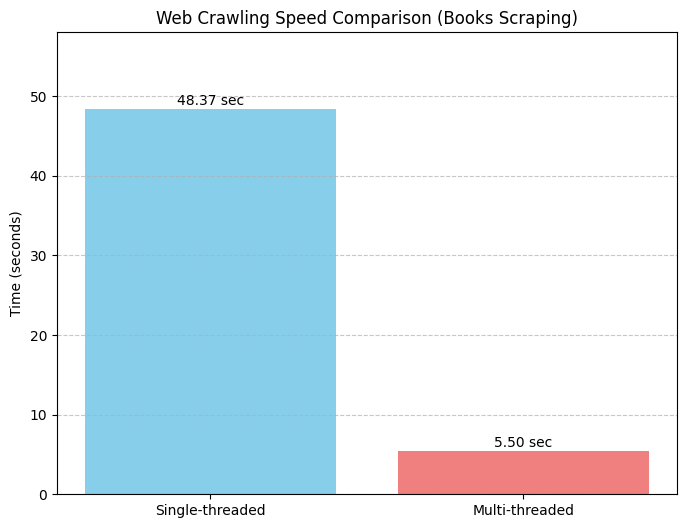


--- All processes completed ---


In [13]:
# -------------------------------------------------------------------------
# 5. Visualize Speed Comparison
# -------------------------------------------------------------------------

labels = ['Single-threaded', 'Multi-threaded']
times = [time_single, time_multi]

plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=['skyblue', 'lightcoral'])
plt.ylabel('Time (seconds)') # Y-axis label
plt.title('Web Crawling Speed Comparison (Books Scraping)') # Chart title
plt.text(labels[0], times[0] + 0.5, f'{times[0]:.2f} sec', ha='center')
plt.text(labels[1], times[1] + 0.5, f'{times[1]:.2f} sec', ha='center')
plt.ylim(0, max(times) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- All processes completed ---")